In [10]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
train_dataset = torchvision.datasets.MNIST(root="data/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)

2


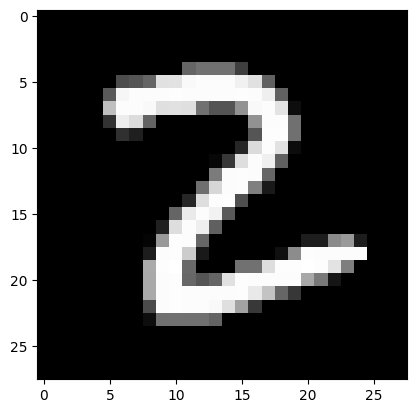

In [5]:
X, y = train_dataset[830]

print(y)
plt.imshow(X[0], 'gray')
plt.show()

In [6]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

In [7]:
next(iter(train_loader))[0].size(), next(iter(train_loader))[1].size()

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

### Create the model

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1) # Flatten
        x = self.fc(x)
        
        return x
    
model = SimpleCNN().to(device)

In [12]:
model

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

### Train and Validation

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    
    train_loss = 0
    valid_loss = 0
    
    train_corrects = 0
    valid_corrects = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_corrects += (labels == torch.max(outputs, 1).indices).sum().item()
        
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        valid_loss += loss.item()
        valid_corrects += (labels == torch.max(outputs, 1).indices).sum().item()
        
    print("Epoch [{}/{}] : Train Loss = {:.4f}, Valid Loss = {:.4f}, Train Acc = {:.4f}, Valid Acc = {:.4f}"
          .format(epoch, num_epochs,
                  train_loss / len(train_loader),
                  valid_loss / len(valid_loader),
                  train_corrects / (len(train_loader) * batch_size),
                  valid_corrects / (len(valid_loader) * batch_size)
        ))

Epoch [0/5] : Train Loss = 0.0407, Valid Loss = 0.0455, Train Acc = 0.9872, Valid Acc = 0.9786
Epoch [1/5] : Train Loss = 0.0320, Valid Loss = 0.0287, Train Acc = 0.9897, Valid Acc = 0.9862
Epoch [2/5] : Train Loss = 0.0252, Valid Loss = 0.0273, Train Acc = 0.9914, Valid Acc = 0.9862
Epoch [3/5] : Train Loss = 0.0198, Valid Loss = 0.0303, Train Acc = 0.9934, Valid Acc = 0.9855
Epoch [4/5] : Train Loss = 0.0157, Valid Loss = 0.0276, Train Acc = 0.9944, Valid Acc = 0.9872
